In [2]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import torch
from scipy import stats
import os
import xarray as xr
import sys

cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import fit_polynomial_methods as fit
import data_organize as dorg

In [38]:
# Adjust parameters here to customize run

### CONSTANTS ####
c = 2.99792458e8                      # [m/s] Speed of light
dt = 25e-12                   # [s] TCSPC resolution

### PARAMETERS ###
window_bnd = [30e-9, 33e-9]       # [s] Set boundaries for binning to exclude outliers
exclude_shots = True                     # Set TRUE to exclude data to work with smaller dataset
max_lsr_shot1 = 10007
max_lsr_shot2 = 1005993                   # Include up to certain number of laser shots
deadtime = 25e-9                  # [s] Acquisition deadtime

# Make sure file location is accurate
cwd = os.getcwd()
data_dir = cwd + r'/../Data/Deadtime_Experiments_HiFi'
fname1 = r'/Dev_0_-_2022-04-15_11.10.35.ARSENL.OD10.ARSENL.nc'
fname2 = r'/Dev_0_-_2022-04-15_11.24.55.ARSENL.OD30.ARSENL.nc'

In [39]:
flight_time1, n_shots1, t_det_lst1 = dorg.data_organize(dt, data_dir, fname1, window_bnd, max_lsr_shot1, exclude_shots)
flight_time2, n_shots2, t_det_lst2 = dorg.data_organize(dt, data_dir, fname2, window_bnd, max_lsr_shot2, exclude_shots)

In [45]:
print('\n{}:'.format(fname1[36:40]))
print('Number of detections: {}'.format(len(flight_time1)))
print('Number of laser shots: {}'.format(n_shots1))
print('\n{}:'.format(fname2[36:40]))
print('Number of detections: {}'.format(len(flight_time2)))
print('Number of laser shots: {}'.format(n_shots2))


OD10:
Number of detections: 4730
Number of laser shots: 10007

OD30:
Number of detections: 3387
Number of laser shots: 1005993


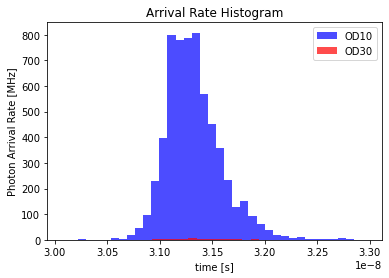

In [49]:
# Scaled time-of-flight histogram
fig = plt.figure()
ax = fig.add_subplot(111)
n, bin_edges = np.histogram(flight_time1, bins=34)
binwidth = np.diff(bin_edges)[0]
N = n / binwidth / n_shots1  # [Hz] Scale counts to arrival rate
center = (bin_edges[:-1]+bin_edges[1:]) / 2
ax.bar(center, N/1e6, align='center', width=binwidth, color='b', alpha=0.7, label=fname1[36:40])
n, bin_edges = np.histogram(flight_time2, bins=34)
binwidth = np.diff(bin_edges)[0]
N = n / binwidth / n_shots2  # [Hz] Scale counts to arrival rate
center = (bin_edges[:-1]+bin_edges[1:]) / 2
ax.bar(center, N/1e6, align='center', width=binwidth, color='r', alpha=0.7, label=fname2[36:40])
ax.set_title('Arrival Rate Histogram')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [MHz]')
ax.legend()
plt.show()

## Now applying the curve_fit routine to my data. Code designed after Matt Hayman's "Fit_TimeTag_Gaussian.ipynb" and adapted to fit to N-order exponentiated polynomial.

In [95]:
# Generate fit and validation sets
# The target is assumed to be stationary so I can split the data into halves
split_value = int(len(flight_time1)//2)
t_phot_fit = flight_time1[:split_value]
t_phot_val = flight_time1[split_value:]
t_phot_no_dtime = flight_time2[:]
# t_phot_fit = flight_time1[:]
# t_phot_val = flight_time2[:]

# Adjust number of laser shots corresponding to fit and val sets
ratio_fit_split = len(t_phot_fit) / len(flight_time1)
ratio_val_split = len(t_phot_val) / len(flight_time2)
n_shots_fit = np.floor(n_shots1*ratio_fit_split).astype(int)
n_shots_val = np.floor(n_shots1*ratio_val_split).astype(int)
n_shots_no_dtime = n_shots2
# n_shots_fit = n_shots1
# n_shots_val = n_shots2

t_phot_fit_tnsr = torch.tensor(t_phot_fit.to_numpy())
t_phot_val_tnsr = torch.tensor(t_phot_val.to_numpy())
t_phot_no_dtime_tnsr = torch.tensor(t_phot_no_dtime.to_numpy())

In [96]:
# optimization parameters

rel_step_lim = 1e-8  # termination criteria based on step size
max_epochs = 400     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations
intgrl_N = 10000        # Set number of steps in numerical integration

In [97]:
# I define the max/min times as fixed values. They are the upper/lower bounds of the fit.
# Time vector per shot
t_min = window_bnd[0]
t_max = window_bnd[1]
dt = dt
t_fine = np.arange(t_min, t_max, dt)

In [98]:
# Set iterate to True if you want to iterate through increasing complexity. 
# Otherwise set to False if you want to check a single polynomial order.
single_step_iter = True
M_max = 21  # Max polynomial complexity to test if iterating
M_lst = np.arange(5, 19, 1)

# Set True to include deadtime in noise model
include_deadtime = True

In [99]:
# Generate "active-ratio histogram" that adjusts the histogram proportionally according to how many bins the detector was "active vs dead"
active_ratio_hst1 = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst1)
if not include_deadtime:
    active_ratio_hst1 = torch.ones(len(active_ratio_hst))    
    
active_ratio_hst2 = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst2)
if not include_deadtime:
    active_ratio_hst2 = torch.ones(len(active_ratio_hst))    
    

Time elapsed:

Order=1: 0.56 sec
Order=2: 0.71 sec
Order=3: 0.63 sec
Order=4: 0.28 sec
Order=5: 0.61 sec
Order=6: 0.79 sec
Order=7: 0.64 sec
Order=8: 0.75 sec
Order=9: 0.81 sec
Order=10: 0.92 sec
Order=11: 1.01 sec
Order=12: 1.17 sec
Order=13: 1.02 sec
Order=14: 1.40 sec
Order=15: 1.96 sec
Order=16: 2.88 sec
Order=17: 3.66 sec
Order=18: 5.00 sec
Order=19: 9.09 sec
Order=20: 12.45 sec


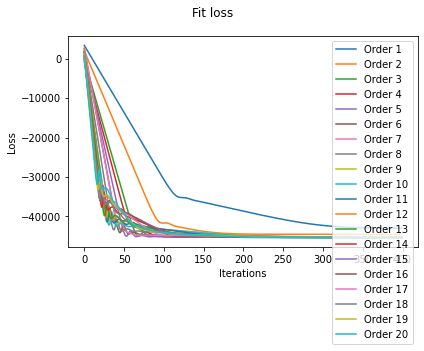

In [100]:
if single_step_iter:
    M_lst = np.arange(1, M_max, 1)
else:
    M_lst = M_lst
    M_max = max(M_lst)

iter_len = len(M_lst)
fig = plt.figure()
val_loss_arr = np.zeros(M_max+1)
no_dtime_loss_arr = np.zeros(M_max+1)
coeffs = np.zeros((M_max+1, M_max+1))
fit_rate_fine = np.zeros((M_max+1, len(t_fine)))
print('Time elapsed:\n')

# Iterate through increasing polynomial complexity. 
# Compare fit w/ validation set and use minimum loss find optimal polynomial order.
for i in range(len(M_lst)):    
    # initialize for fit loop
    M = M_lst[i]  # Polynomial order  (e.g., x^2 --> M=2)
    fit_model = fit.Fit_Pulse(M, t_min, t_max)
    optimizer = torch.optim.Adam(fit_model.parameters(), lr=learning_rate)
    epoch = 0
    rel_step = 1e3*rel_step_lim
    fit_loss_lst = []
    val_loss_lst = []
    rel_step_lst = []

    init_C = np.zeros(M+1)
    for j in range(M+1):
        init_C[j] = fit_model.C[j].item()

    # set the loss function to use a Poisson point process likelihood function
    loss_fn = fit.pois_loss

    # perform fit
    start = time.time()
    t_fit_norm = fit_model.tstamp_condition(t_phot_fit_tnsr, t_min, t_max)
    t_val_norm = fit_model.tstamp_condition(t_phot_val_tnsr, t_min, t_max)
    t_no_dtime_norm = fit_model.tstamp_condition(t_phot_no_dtime_tnsr, t_min, t_max)
    t_intgrl = fit.cheby_poly(torch.linspace(0, 1, intgrl_N), M)
    while rel_step > rel_step_lim and epoch < max_epochs:
        fit_model.train()
        pred_fit, integral_fit = fit_model(intgrl_N, active_ratio_hst1, t_fit_norm, t_intgrl, cheby=True)
        loss_fit = loss_fn(pred_fit, integral_fit*n_shots_fit)  # add regularization here
        fit_loss_lst += [loss_fit.item()]

        # calculate relative step as an average over the last term_persist iterations
        if epoch == 0:
            rel_step_lst+=[1e3*rel_step_lim]
            rel_step = 1e3*rel_step_lim
        else:
            rel_step_lst+=[(fit_loss_lst[-2]-fit_loss_lst[-1])/np.abs(fit_loss_lst[-2])]
            rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

        # update estimated parameters
        loss_fit.backward()
        optimizer.step()

        # zero out the gradient for the next step
        optimizer.zero_grad()

        epoch+=1

    pred_mod_seg, __ = fit_model(intgrl_N, active_ratio_hst1, torch.tensor(t_fine), t_intgrl, cheby=False)
    fit_rate_fine[M, :] = pred_mod_seg.detach().numpy().T
    coeffs[M, 0:M+1] = fit_model.C.detach().numpy().T
    
    # Calculate validation loss
    # Using fit generated from fit set, calculate loss when applied to validation set
    pred_val, integral_val = fit_model(intgrl_N, active_ratio_hst1, t_val_norm, t_intgrl, cheby=True)
    loss_val = loss_fn(pred_val, integral_val*n_shots_fit)
    val_loss_arr[M] = loss_val
    # Now use the generated fit and validate against reference set (e.g., no deadtime, high-OD data)
    pred_no_dtime, integral_no_dtime = fit_model(intgrl_N, active_ratio_hst2, t_no_dtime_norm, t_intgrl, cheby=True)
    loss_no_dtime = loss_fn(pred_no_dtime, integral_no_dtime*n_shots_fit)
    no_dtime_loss_arr[M] = loss_no_dtime
        
    end = time.time()
    print('Order={}: {:.2f} sec'.format(M, end-start))
    
    plt.plot(fit_loss_lst, label='Order {}'.format(M))

plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.suptitle('Fit loss')
plt.tight_layout()
plt.legend()
plt.show()

In [101]:
for i in range(len(M_lst)):
    print('Final validation loss value for order {}: {:.2f}'.format(M_lst[i], val_loss_arr[M_lst[i]]))

Final validation loss value for order 1: -42985.72
Final validation loss value for order 2: -44574.03
Final validation loss value for order 3: -45278.67
Final validation loss value for order 4: -45227.18
Final validation loss value for order 5: -45222.69
Final validation loss value for order 6: -45238.15
Final validation loss value for order 7: -45357.80
Final validation loss value for order 8: -45416.47
Final validation loss value for order 9: -45393.37
Final validation loss value for order 10: -45396.23
Final validation loss value for order 11: -45360.95
Final validation loss value for order 12: -45287.31
Final validation loss value for order 13: -45276.19
Final validation loss value for order 14: -45285.60
Final validation loss value for order 15: -45342.56
Final validation loss value for order 16: -45333.41
Final validation loss value for order 17: -45333.99
Final validation loss value for order 18: -45301.11
Final validation loss value for order 19: -45327.33
Final validation loss

In [102]:
for i in range(len(M_lst)):
    print('Final validation loss (vs high OD) value for order {}: {:.2f}'.format(M_lst[i], no_dtime_loss_arr[M_lst[i]]))

Final validation loss (vs high OD) value for order 1: -61682.20
Final validation loss (vs high OD) value for order 2: -63796.93
Final validation loss (vs high OD) value for order 3: -64019.30
Final validation loss (vs high OD) value for order 4: -63780.72
Final validation loss (vs high OD) value for order 5: -63356.82
Final validation loss (vs high OD) value for order 6: -63442.46
Final validation loss (vs high OD) value for order 7: -63765.47
Final validation loss (vs high OD) value for order 8: -63933.40
Final validation loss (vs high OD) value for order 9: -63836.30
Final validation loss (vs high OD) value for order 10: -63788.95
Final validation loss (vs high OD) value for order 11: -63515.94
Final validation loss (vs high OD) value for order 12: -63200.60
Final validation loss (vs high OD) value for order 13: -63157.70
Final validation loss (vs high OD) value for order 14: -63173.21
Final validation loss (vs high OD) value for order 15: -63400.22
Final validation loss (vs high OD)

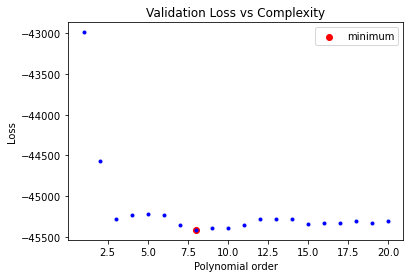

In [105]:
minx, miny = np.argmin(val_loss_arr), min(val_loss_arr)

plt.plot(M_lst, val_loss_arr[M_lst], 'b.')
plt.scatter(minx, miny,c='r', label='minimum')
plt.title('Validation Loss vs Complexity')
plt.ylabel('Loss')
plt.xlabel('Polynomial order')
plt.legend()
plt.show()

In [106]:
# Choose order to investigate
order = 8
try:
    model = coeffs[order, 0:order+1]
    for i in range(order+1):
        print('Final C{}: {:.4f}'.format(i, model[i]))
except:
    print("\nERROR: Order exceeds maximum complexity iteration value.\n")

Final C0: 5.4621
Final C1: 5.8872
Final C2: -6.0414
Final C3: -6.0692
Final C4: -6.7878
Final C5: 1.3753
Final C6: 0.3857
Final C7: -3.0940
Final C8: -0.1491


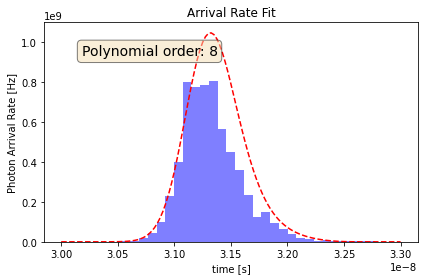

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111)

n, bins = np.histogram(flight_time1, bins=34)
binwidth = np.diff(bins)[0]
N = n / binwidth / n_shots1  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N, align='center', width=binwidth, color='b', alpha=0.5)

# Arrival rate fit
t_fine = np.arange(t_min, t_max, dt)
fit_rate_seg = fit_rate_fine[order, :]
ax.plot(t_fine, fit_rate_seg, 'r--')
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [Hz]')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.1, 0.90, 'Polynomial order: {}'.format(order), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()
